In [1]:
# %pip install nest_asyncio
# %pip install kitchenai-whisk
# %pip install llama-index
# %pip install llama-index-vector-stores-chroma 
# %pip install chromadb
# %pip install tiktoken
# %pip install kitchenai-llama


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may ne

# What we're doing different. 

Promoting loosely coupled architecture through message brokers and abstracting away HTTP complexities.

We separate applied AI responsibilities and bring more control to your experts

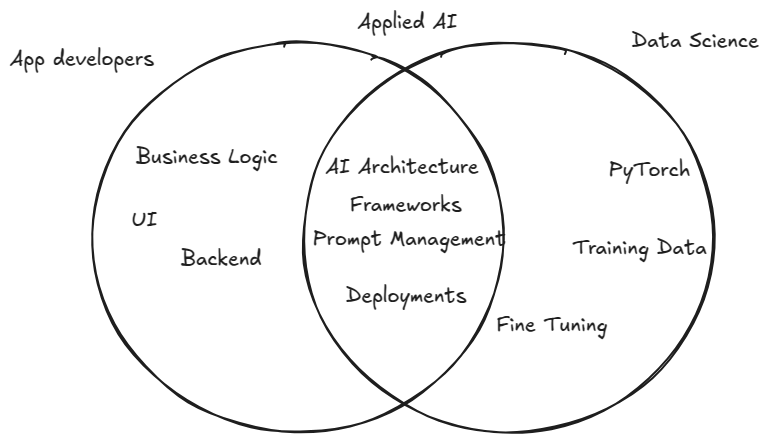

In [2]:
from IPython.display import display, Image

display(Image(filename="./applied-ai.png", width=900, height=300))

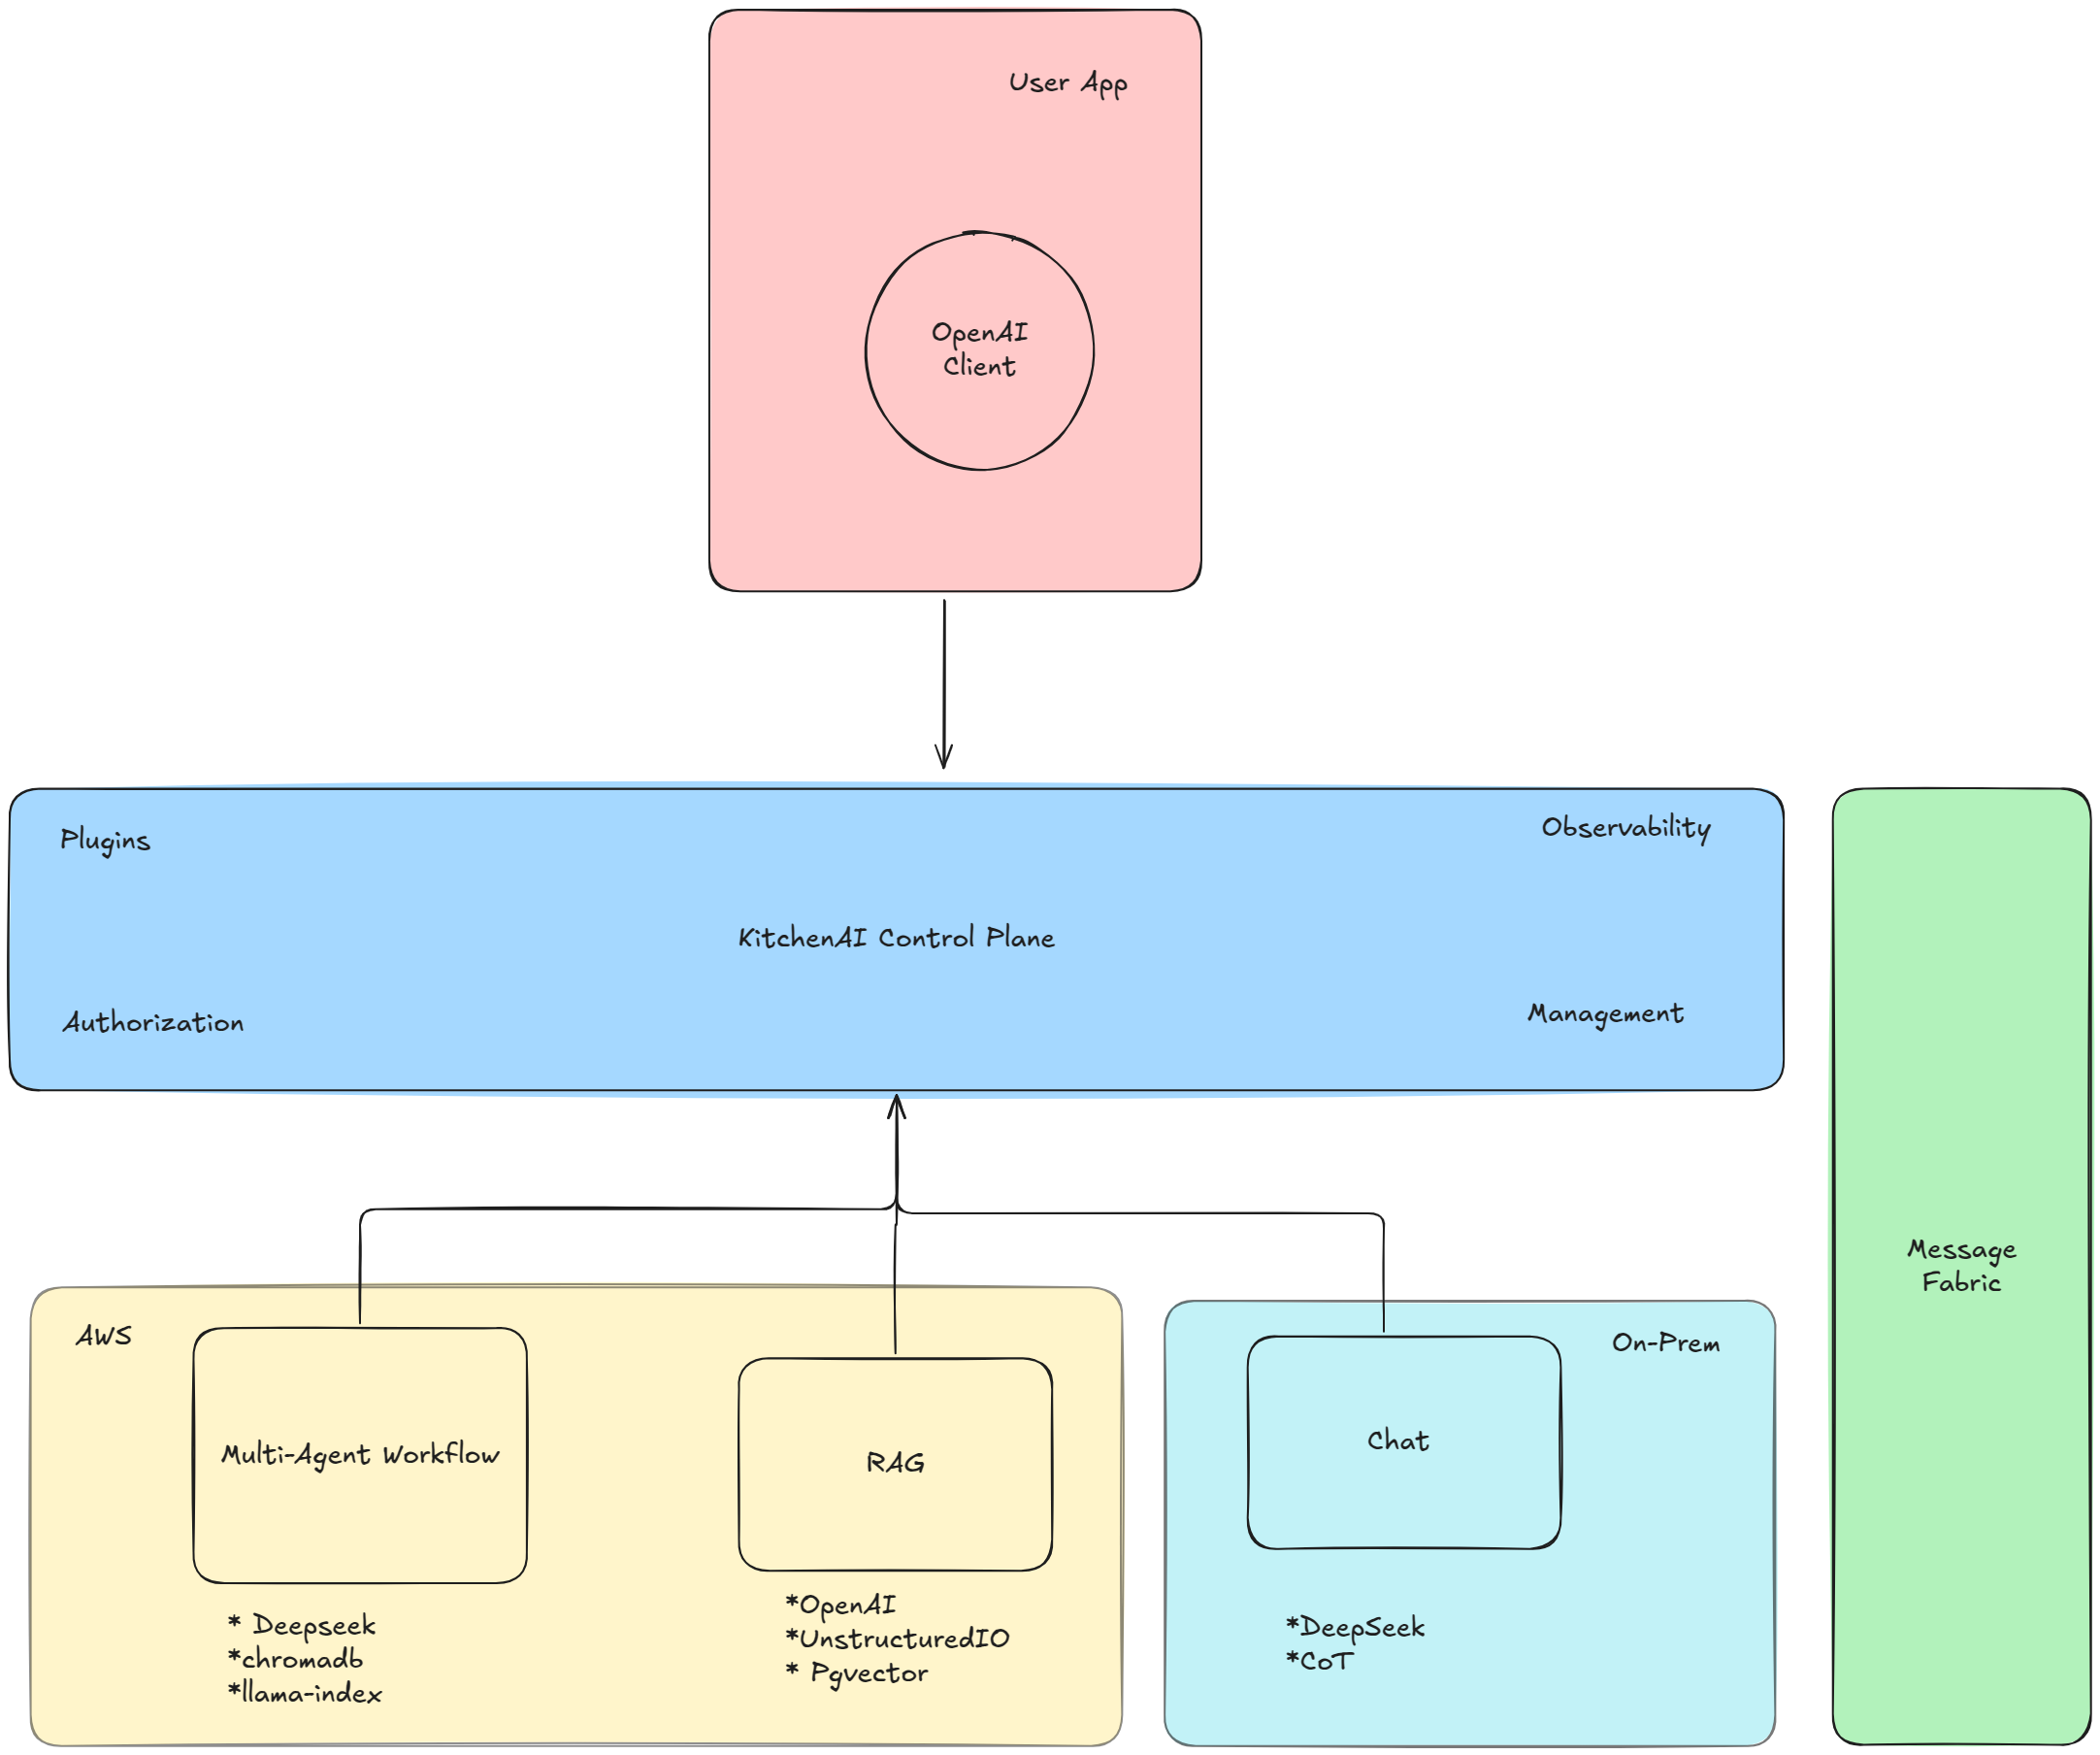

In [3]:
from IPython.display import display, Image

display(Image(filename="./message-fabric.png", width=900, height=300))

In [4]:
from whisk.kitchenai_sdk.kitchenai import KitchenAIApp
from whisk.kitchenai_sdk.schema import (
    WhiskQuerySchema,
    WhiskQueryBaseResponseSchema,
    WhiskStorageSchema,
    WhiskStorageResponseSchema,
    TokenCountSchema
)

from llama_index.core import VectorStoreIndex, StorageContext, Document
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.core.extractors import TitleExtractor, QuestionsAnsweredExtractor
from llama_index.llms.openai import OpenAI
from llama_index.core.callbacks import CallbackManager, TokenCountingHandler
from llama_index.core import Settings
import chromadb
import logging
import asyncio
import tiktoken
from whisk.client import WhiskClient
import os
import tempfile
from pathlib import Path

# Global dependencies 

These dependencies can be things like any vector store, llm model, etc

In [5]:
# Setup logging
logger = logging.getLogger(__name__)

# Initialize token counter
token_counter = TokenCountingHandler(
    tokenizer=tiktoken.encoding_for_model("gpt-3.5-turbo").encode
)
Settings.callback_manager = CallbackManager([token_counter])

# Initialize LLM
llm = OpenAI(model="gpt-3.5-turbo")
Settings.llm = llm

# Initialize Vector Store
chroma_client = chromadb.PersistentClient(path="chroma_db")
chroma_collection = chroma_client.get_or_create_collection("quickstart")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

# Initialize KitchenAI App
kitchen = KitchenAIApp(namespace="my-remote-client")

# Query Function

defing a query handler with the label "query" will allow kitchenai to register this function with the control plane. It now can be targeted and used with the combination of the bento box id. 

In [6]:
@kitchen.query.handler("query")
async def query_handler(data: WhiskQuerySchema) -> WhiskQueryBaseResponseSchema:
    """Query handler with RAG. We can implement any AI logic 
    as long as it fulfills the WhiskQueryBaseResponseSchema and handles the WhiskQuerySchema"""
    filters = None
    if data.metadata:
        from llama_index.core.vector_stores.types import MetadataFilter, MetadataFilters
        print(data.metadata)
        filter_list = [
            MetadataFilter(key=key, value=value)
            for key, value in data.metadata.items()
        ]
        filters = MetadataFilters(filters=filter_list)

    # Create index and query engine
    index = VectorStoreIndex.from_vector_store(vector_store)
    query_engine = index.as_query_engine(
        chat_mode="best",
        filters=filters,
        llm=llm,
        verbose=True
    )

    # Execute query
    response = await query_engine.aquery(data.query)

    # Get token counts
    token_counts = {
        "embedding_tokens": token_counter.total_embedding_token_count,
        "llm_prompt_tokens": token_counter.prompt_llm_token_count,
        "llm_completion_tokens": token_counter.completion_llm_token_count,
        "total_llm_tokens": token_counter.total_llm_token_count
    }
    token_counter.reset_counts()

    return WhiskQueryBaseResponseSchema.from_llama_response(
        data,
        response,
        token_counts=TokenCountSchema(**token_counts),
        metadata={"token_counts": token_counts, **data.metadata} if data.metadata else {"token_counts": token_counts}
    )



# Query With No RAG

You can create as many labels as you want for multiple types of the same handler class. In this scenario, we want a simple query handler named "query-no-rag" and a more complex one that handles rag with "query". You can mix and match however we want. 

In [7]:
@kitchen.query.handler("query-no-rag")
async def query_handler(data: WhiskQuerySchema) -> WhiskQueryBaseResponseSchema:
    """Query handler with No RAG. We can implement any AI logic """
    try:
        # Execute query using llm.acomplete
        response = await llm.acomplete(data.query)
        print("IM Making a change here")

        # Get token counts
        token_counts = {
            "llm_prompt_tokens": token_counter.prompt_llm_token_count,
            "llm_completion_tokens": token_counter.completion_llm_token_count,
            "total_llm_tokens": token_counter.total_llm_token_count
        }
        token_counter.reset_counts()

        return WhiskQueryBaseResponseSchema.from_llm_invoke(
            data.query,
            response.text,
            token_counts=TokenCountSchema(**token_counts),
            metadata={"token_counts": token_counts, **data.metadata} if data.metadata else {"token_counts": token_counts}
        )
    except Exception as e:
        logger.error(f"Error in query handler: {str(e)}")
        raise



# Storage Function.

You can optionally create storage functions that can handle blob data. KitchenAI provides your function with bytes content allowing you to manage, manipulate, and store the file



> currently disabled for playground usage but active in local self hosted mode.

In [11]:
#This is a helper function from the kitchenai-llama library. The parser uses default llama index loaders but 
#falls back to llama cloud for files it cannot parse or if a file is greater that 150MB

from kitchenai_llama.storage.llama_parser import Parser

In [9]:
@kitchen.storage.handler("storage")
async def storage_handler(data: WhiskStorageSchema) -> WhiskStorageResponseSchema:
    """Storage handler for document ingestion"""
    try:
        # Create a temporary directory
        with tempfile.TemporaryDirectory() as temp_dir:
            # Use the original filename for the temporary file
            temp_file_path = Path(temp_dir) / Path(data.name).name
            
            # Write bytes data to temporary file
            with open(temp_file_path, 'wb') as f:
                f.write(data.data)
            
            # Initialize parser and load the file
            parser = Parser(api_key=os.environ.get("LLAMA_CLOUD_API_KEY", None))
            response = parser.load(str(temp_dir), metadata=data.metadata)
            
            # Setup storage context and process documents
            storage_context = StorageContext.from_defaults(vector_store=vector_store)
            
            # Create index with transformations
            VectorStoreIndex.from_documents(
                response["documents"],
                storage_context=storage_context,
                transformations=[
                    TokenTextSplitter(),
                    TitleExtractor(),
                    QuestionsAnsweredExtractor()
                ],
                show_progress=True
            )
            

            return WhiskStorageResponseSchema(
                id=data.id,
                name=data.name,
                label=data.label,
                data=data.data,
            )
            
    except Exception as e:
        logger.error(f"Error in storage handler: {str(e)}")
        raise

## Connecting to a control plane 
By running this cell, you'll connect to the control plane via this client id. 

the uncommented section is for connecting to the local control plane if you are running self hosted kitchenai. 

the commented section is for connecting to the playground control plane after generating a client it. 
["playground"](https://playground.kitchenai.dev/)

In [10]:


# Remote Playground client
# client = WhiskClient(
#     nats_url="nats://nats.playground.kitchenai.dev:4222",
#     client_id="<your playground generated client id>",
#     user="playground",
#     password="kitchenai_playground",
#     kitchen=kitchen,
# )
# await client.run()


local_client = WhiskClient(
    nats_url="nats://localhost:4222",
    client_id="61737fe4-d76c-4146-8d48-58a7b923ab78",
    user="playground",
    password="kitchenai_playground",
    kitchen=kitchen,
)
await local_client.run()

KitchenAI Configuration:

{
    'namespace': 'my-remote-client',
    'query_handlers': ['query', 'query-no-rag'],
    'storage_handlers': ['storage'],
    'embed_handlers': [],
    'agent_handlers': []
}

✓ Successfully registered client!

2025-02-07 11:42:54,201 INFO     - FastStream app starting...


2025-02-07 11:42:54,204 INFO     - queue | kitchenai.service.61737fe4-d76c-4146-8d48-58a7b923ab78.query.*          |            - `HandleQuery` waiting for messages
2025-02-07 11:42:54,204 INFO     - queue | kitchenai.service.61737fe4-d76c-4146-8d48-58a7b923ab78.heartbeat        |            - `HandleHeartbeat` waiting for messages
2025-02-07 11:42:54,205 INFO     - queue | kitchenai.service.61737fe4-d76c-4146-8d48-58a7b923ab78.storage.*        |            - `HandleStorage` waiting for messages
2025-02-07 11:42:54,206 INFO     - queue | kitchenai.service.61737fe4-d76c-4146-8d48-58a7b923ab78.storage.*.delete |            - `HandleStorageDelete` waiting for messages


2025-02-07 11:42:54,206 INFO     - FastStream app started successfully! To exit, press CTRL+C


2025-02-07 11:43:09,191 INFO     - queue | kitchenai.service.61737fe4-d76c-4146-8d48-58a7b923ab78.query.*          | e3a3d442-b - Received
2025-02-07 11:43:09,193 INFO     - queue | kitchenai.service.61737fe4-d76c-4146-8d48-58a7b923ab78.query.*          | e3a3d442-b - Query request: query='whats the most important part of the readme?' stream=False stream_id=None metadata={'user_id': '123'} label='query-no-rag' messages=[{'role': 'user', 'content': 'whats the most important part of the readme?', 'refusal': None, 'name': None, 'audio': None, 'tool_calls': None, 'function_call': None}] request_id='98ec82e2-5186-47c1-bca8-c769d606c8f9' timestamp=1738950189.1905468 client_id='61737fe4-d76c-4146-8d48-58a7b923ab78'
IM Making a change here
2025-02-07 11:43:11,134 INFO     - queue | kitchenai.service.61737fe4-d76c-4146-8d48-58a7b923ab78.query.*          | e3a3d442-b - Processed
2025-02-07 11:43:33,202 INFO     - queue | kitchenai.service.61737fe4-d76c-4146-8d48-58a7b923ab78.query.*          | 0

2025-02-07 11:49:11,650 INFO     - FastStream app shutting down...
2025-02-07 11:49:11,655 INFO     - FastStream app shut down gracefully.
